In [1]:
from gengraph import graph
from fileio import FileIO, collapse
import numpy as np
import pandas as pd

from pathlib import Path

import os, sys, mmap
import re
from collections import defaultdict

In [2]:
#df = pd.read_csv("~katie/collected_results.csv")
df = pd.read_csv("~/beehive/results/vr_sharded/collected_results_perf_gov_irqs0.csv")
df["version"] = "v1.0"
meta = list(df)
df["error"] = "no"

In [3]:
print(df)
print(meta)

            config  num_shards  num_client_nodes  num_node_threads  num_txns  \
0    100gb_cluster           1                 1                 1    124055   
1    100gb_cluster           1                 1                 2    240251   
2    100gb_cluster           1                 1                 4    393236   
3    100gb_cluster           1                 1                 6    463518   
4    100gb_cluster           1                 1                 8    490816   
..             ...         ...               ...               ...       ...   
171   fpga_cluster           4                 2                12   1173767   
172   fpga_cluster           4                 2                16   1253830   
173   fpga_cluster           4                 2                24   1400247   
174   fpga_cluster           4                 2                32   1526535   
175   fpga_cluster           4                 2                64   1638708   

      thruput     lat_avg  lat_med  lat

Plotting [12405.5, 24025.1, 21751.5, 39323.6, 38042.8, 46351.8, 49081.6, 50928.1, 45716.8, 48023.8, 45132.4, 48826.0, 47130.3, 46134.2, 46924.6, 48750.9, 46525.6, 45882.6, 46476.9, 48854.8, 46329.6, 49956.3] by [83.0, 83.0, 87.0, 91.0, 92.0, 112.0, 146.0, 139.0, 200.0, 232.0, 247.0, 310.0, 323.0, 409.0, 477.0, 457.0, 641.0, 648.0, 975.0, 1257.0, 1328.0, 2504.0]
Plotting [14070.3, 30468.0, 26501.1, 47911.8, 46029.7, 58491.8, 60324.8, 58612.3, 50188.5, 52760.3, 50564.3, 50372.0, 52099.9, 46660.7, 48854.1, 53417.9, 49764.3, 50477.7, 49744.4, 47899.8, 48960.8, 49772.9] by [73.0, 50.0, 75.0, 67.0, 77.0, 87.0, 117.0, 121.0, 197.0, 222.0, 231.0, 312.0, 304.0, 432.0, 488.0, 446.0, 644.0, 627.0, 956.0, 1333.0, 1296.0, 2546.0]
Saved graph to 1,num_client_nodes,num_node_threads,num_txns,lat_avg,lat_99,energy_j,v1.0,thruput vs lat_med vs config,


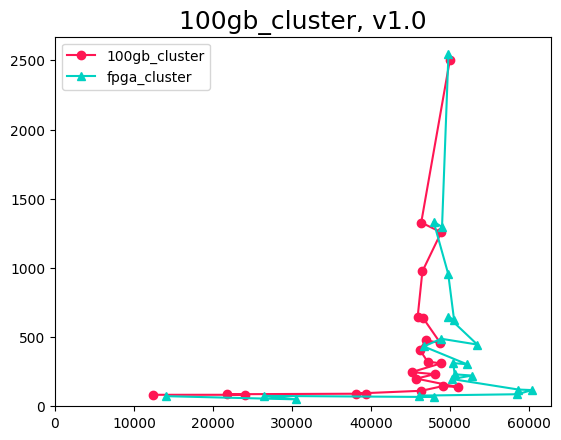

In [4]:
df["clients"] = df["num_client_nodes"] * df["num_node_threads"]
df = df.sort_values(["clients", "config"], kind="stable")
#df["config + num_client_nodes"] = df["config"] + " + " + df["num_client_nodes"].apply(str)
df["config + num_client_nodes"] = df["num_client_nodes"].apply(str) + "node(s), " + df["config"].apply(lambda x: "Beehive" if x == "fpga_cluster" else "CPU")
graph(df.loc[df["num_shards"] == 1], meta, "thruput", "lat_med", "config", sortX=False)

Plotting [21.7515, 38.0428, 50.9281, 45.132400000000004, 47.130300000000005] by [87.0, 92.0, 139.0, 247.0, 323.0]
Plotting [26.501099999999997, 46.0297, 58.612300000000005, 50.5643, 52.0999] by [75.0, 77.0, 121.0, 231.0, 304.0]
mismatch in 2 and 1
Plotting [21.7592, 40.283300000000004, 58.1878, 66.9037, 69.9399, 74.1375, 76.9012, 80.69030000000001, 84.42439999999999] by [87.0, 89.0, 115.0, 157.0, 208.0, 251.0, 292.0, 376.0, 540.0]
Plotting [26.6064, 50.522800000000004, 68.0947, 76.3878, 83.034, 82.5008, 83.45639999999999, 88.062, 92.83460000000001] by [74.0, 69.0, 98.0, 134.0, 181.0, 228.0, 269.0, 346.0, 494.0]
mismatch in 3 and 2
Plotting [21.6726, 41.4826, 64.3427, 75.4003, 84.2359, 89.8577, 94.6558, 104.9902, 113.6357, 119.2187] by [87.0, 89.0, 102.0, 131.0, 162.0, 194.0, 226.0, 278.0, 385.0, 489.0]
Plotting [26.7737, 49.5638, 74.1232, 86.66380000000001, 94.25869999999999, 102.06689999999999, 105.07889999999999, 114.4489, 121.1704, 129.5358] by [74.0, 75.0, 88.0, 117.0, 147.0, 175.0

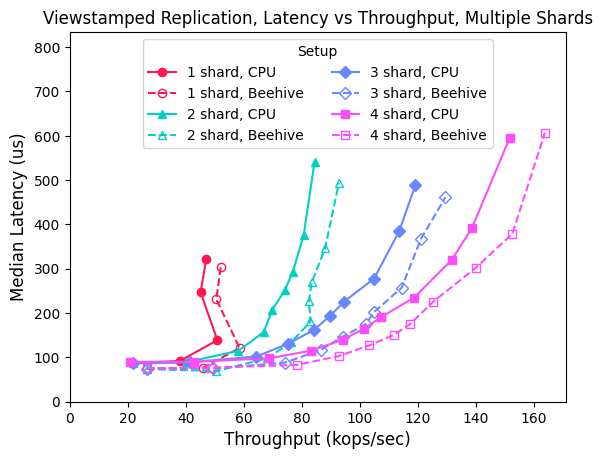

In [7]:
#df["config + num_shards"] = df["config"] + " + " + df["num_shards"].apply(str)
df["config + num_shards"] = df["num_shards"].apply(str) + " shard, " + df["config"].apply(lambda x: "Beehive" if x == "fpga_cluster" else "CPU")
df = df.sort_values(["num_shards", "config", "clients", "num_client_nodes"], kind="stable")
df = df.loc[df["lat_med"] < 800]
df = df.loc[(df["num_shards"] > 1) | (df["lat_med"] < 400)]
df = df.loc[(df["num_shards"] > 2) | (df["lat_med"] < 600)]
"""
df = df.loc[(df["num_shards"] <= 1) | (df["thruput"] > 50000)]
df = df.loc[(df["num_shards"] <= 2) | (df["thruput"] > 60000)]
df = df.loc[(df["num_shards"] <= 3) | (df["thruput"] > 80000)]
df = df.loc[(df["num_shards"] <= 4) | (df["thruput"] > 90000)]
"""
df = df.loc[df["num_client_nodes"] == 2]
df["thruput kops"] = df["thruput"] / 1000
#for x in range(11):
graph(df, meta, "thruput kops", "lat_med", "config + num_shards", 
      "Throughput (kops/sec)", "Median Latency (us)", "Setup",
      symbolProp="num_shards", sortX=False, 
      title="Viewstamped Replication, Latency vs Throughput, Multiple Shards",
      extraTop=200, ncols=2, markersize=6, legendLoc=9, font_sizes=[10,12,12])

In [6]:
#df.loc[df["config + num_shards"] == "100gb_cluster + 1"]
#print(df["config + num_shards"].to_string())
#print(df.to_string())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)
#print(pd.unique(df["config + num_shards"]))

,config,num_shards,num_client_nodes,num_node_threads,num_txns,thruput,lat_avg,lat_med,lat_99,energy_j,version,error,clients,config + num_client_nodes,config + num_shards,thruput kops
11,100gb_cluster,1,2,1,217515,21751.5,86.092812,87,135,519.289429,v1.0,no,2,"2node(s), CPU","1 shard, CPU",21.7515
12,100gb_cluster,1,2,2,380428,38042.8,100.042168,92,211,518.605896,v1.0,no,4,"2node(s), CPU","1 shard, CPU",38.0428
13,100gb_cluster,1,2,4,509281,50928.1,151.889370,139,309,525.084717,v1.0,no,8,"2node(s), CPU","1 shard, CPU",50.9281
14,100gb_cluster,1,2,6,451324,45132.4,259.835721,247,484,520.457947,v1.0,no,12,"2node(s), CPU","1 shard, CPU",45.1324
15,100gb_cluster,1,2,8,471303,47130.3,333.022302,323,588,521.235718,v1.0,no,16,"2node(s), CPU","1 shard, CPU",47.1303
99,fpga_cluster,1,2,1,265011,26501.1,70.346095,75,143,252.887195,v1.0,no,2,"2node(s), Beehive","1 shard, Beehive",26.5011
100,fpga_cluster,1,2,2,460297,46029.7,82.139714,77,197,254.850728,v1.0,no,4,"2node(s), Beehive","1 shard, Beehive",46.0297
101,fpga_cluster,1,2,4,586123,58612.3,131.480273,121,267,254.967490,v1.0,no,8,"2node(s), Beehive","1 shard, Beehive",58.6123
102,fpga_cluster,1,2,6,505643,50564.3,231.427731,231,359,255.941678,v1.0,no,12,"2node(s), Beehive","1 shard, Beehive",50.5643
103,fpga_cluster,1,2,8,520999,52099.9,301.106994,304,443,255.076147,v1.0,no,16,"2node(s), Beehive","1 shard, Beehive",52.0999


In [ ]:
import os, sys, mmap
sys.path.append('/home/mgiordan/specpaxos/kvstore/tools/')
from analysis_kvstore import process_file

In [ ]:
fio = FileIO('/home/katie/apiary/beehive-electrode/specpaxos-mod/results_irqs/{config}_1shard_1clientnodes_1threads/client{suffix}')
df, meta = fio.get_raw_data({'config': '100gb_cluster', 'version': '2', 'run_num': 0, 'validate_reads': 'true'}, process_file, suffix=".log", check_errfile=False)

In [ ]:
df["version"] = "v1.0"
meta += ["version"]
df


In [ ]:
df = df.explode(["raw data", "read writes"], ignore_index=True)
meta += ["raw data", "read writes"]

df['read'] = df['read writes'] == 0
df['write'] = df['read writes'] == 1
df['ops'] = 1

df, meta = collapse(df, meta, ["read writes"], {'delta reads': ('read', 'sum'),
                                                    'delta writes': ('write', 'sum'),
                                                    'delta ops': ('ops', 'sum')})
print(df.head())
df[["cum reads", "cum writes", "cum ops"]] = df[["delta reads", "delta writes", "delta ops"]].cumsum()
print(df.head())

cumtotals = df.tail(1)[["cum reads", "cum writes", "cum ops"]].values

df[["reads", "writes", "ops"]] = df[["cum reads", "cum writes", "cum ops"]] / cumtotals

print(df.head())
#df = df.melt(meta + ["error"], ["cum reads", "cum writes", "cum ops"])
df = df.melt(meta + ["error"], ["reads", "writes", "ops"])

print(df.head())
#print(df.sort_values("raw data"))

print(df.head())
graph(df, meta, 'raw data', 'value', 'variable',
                'Latency (us)', 'CDF', 'Variable', markersize=0)

In [ ]:
def calcRight(df, cutoff, direction="right"):
    #return df.iloc[(df.shape[0] * cutoff) // 100]["raw data"]
    rightI = df.loc[df["variable"] == "ops"]["value"].searchsorted(cutoff, "left" if direction == "right" else "right")
    right = df.loc[df["variable"] == "ops"].iloc[rightI]["raw data"]
    return right

In [ ]:
right = calcRight(df, 0.99)
print(right)
graph(df.loc[df["variable"].isin(["reads", "writes"])], meta, 'raw data', 'value', 'variable',
                'Latency (us)', 'CDF', 'Variable', left=85, right=right, markersize=0)
left = calcRight(df, 0.95, "left")
df = df.loc[df["value"] >= 0.95].reset_index()
print(df.head())
graph(df.loc[df["variable"].isin(["reads", "writes"])], meta, 'raw data', 'value', 'variable',
                    'Latency (us) (log scale)', 'CDF', 'Variable', bottom=None, left=left, xscale="log", extra_title="zoomed")